# Residual Networks (ResNet)
:label:`sec_resnet`

As we design increasingly deeper networks it becomes imperative to understand how adding layers can increase the complexity and expressiveness of the network.
Even more important is the ability to design networks where adding layers makes networks strictly more expressive rather than just different.
To make some progress we need a bit of mathematics.


## Function Classes

Consider $\mathcal{F}$, the class of functions that a specific network architecture (together with learning rates and other hyperparameter settings) can reach.
That is, for all $f \in \mathcal{F}$ there exists some set of parameters (e.g., weights and biases) that can be obtained through training on a suitable dataset.
Let us assume that $f^*$ is the "truth" function that we really would like to find.
If it is in $\mathcal{F}$, we are in good shape but typically we will not be quite so lucky.
Instead, we will try to find some $f^*_\mathcal{F}$ which is our best bet within $\mathcal{F}$.
For instance, 
given a dataset with features $\mathbf{X}$
and labels $\mathbf{y}$,
we might try finding it by solving the following optimization problem:

$$f^*_\mathcal{F} \stackrel{\mathrm{def}}{=} \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \text{ subject to } f \in \mathcal{F}.$$

It is only reasonable to assume that if we design a different and more powerful architecture $\mathcal{F}'$ we should arrive at a better outcome. In other words, we would expect that $f^*_{\mathcal{F}'}$ is "better" than $f^*_{\mathcal{F}}$. However, if $\mathcal{F} \not\subseteq \mathcal{F}'$ there is no guarantee that this should even happen. In fact, $f^*_{\mathcal{F}'}$ might well be worse. 
As illustrated by :numref:`fig_functionclasses`,
for non-nested function classes, a larger function class does not always move closer to the "truth" function $f^*$. For instance,
on the left of :numref:`fig_functionclasses`,
though $\mathcal{F}_3$ is closer to $f^*$ than $\mathcal{F}_1$, $\mathcal{F}_6$ moves away and there is no guarantee that further increasing the complexity can reduce the distance from $f^*$.
With nested function classes
where $\mathcal{F}_1 \subseteq \ldots \subseteq \mathcal{F}_6$
on the right of :numref:`fig_functionclasses`,
we can avoid the aforementioned issue from the non-nested function classes.


![For non-nested function classes, a larger (indicated by area) function class does not guarantee to get closer to the "truth" function ($f^*$). This does not happen in nested function classes.](../img/functionclasses.svg)
:label:`fig_functionclasses`

Thus,
only if larger function classes contain the smaller ones are we guaranteed that increasing them strictly increases the expressive power of the network.
For deep neural networks,
if we can 
train the newly-added layer into an identity function $f(\mathbf{x}) = \mathbf{x}$, the new model will be as effective as the original model. As the new model may get a better solution to fit the training dataset, the added layer might make it easier to reduce training errors.

This is the question that He et al. considered when working on very deep computer vision models :cite:`He.Zhang.Ren.ea.2016`. 
At the heart of their proposed *residual network* (*ResNet*) is the idea that every additional layer should 
more easily
contain the identity function as one of its elements. 
These considerations are rather profound but they led to a surprisingly simple
solution, a *residual block*.
With it, ResNet won the ImageNet Large Scale Visual Recognition Challenge in 2015. The design had a profound influence on how to
build deep neural networks.



## (**Residual Blocks**)

Let us focus on a local part of a neural network, as depicted in :numref:`fig_residual_block`. Denote the input by $\mathbf{x}$.
We assume that the desired underlying mapping we want to obtain by learning is $f(\mathbf{x})$, to be used as the input to the activation function on the top.
On the left of :numref:`fig_residual_block`,
the portion within the dotted-line box 
must directly learn the mapping $f(\mathbf{x})$.
On the right,
the portion within the dotted-line box
needs to
learn the *residual mapping* $f(\mathbf{x}) - \mathbf{x}$,
which is how the residual block derives its name.
If the identity mapping $f(\mathbf{x}) = \mathbf{x}$ is the desired underlying mapping,
the residual mapping is easier to learn:
we only need to push the weights and biases
of the
upper weight layer (e.g., fully-connected layer and convolutional layer)
within the dotted-line box
to zero.
The right figure in :numref:`fig_residual_block` illustrates the  *residual block* of ResNet,
where the solid line carrying the layer input 
$\mathbf{x}$ to the addition operator
is called a *residual connection* (or *shortcut connection*).
With residual blocks, inputs can 
forward propagate faster through the residual connections across layers.

![A regular block (left) and a residual block (right).](../img/residual-block.svg)
:label:`fig_residual_block`


ResNet follows VGG's full $3\times 3$ convolutional layer design. The residual block has two $3\times 3$ convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function.
This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together. If we want to change the number of channels, we need to introduce an additional $1\times 1$ convolutional layer to transform the input into the desired shape for the addition operation. Let us have a look at the code below.


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):  #@save
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

This code generates two types of networks: one where we add the input to the output before applying the ReLU nonlinearity whenever `use_1x1conv=False`, and one where we adjust channels and resolution by means of a $1 \times 1$ convolution before adding. :numref:`fig_resnet_block` illustrates this:

![ResNet block with and without $1 \times 1$ convolution.](../img/resnet-block.svg)
:label:`fig_resnet_block`

Now let us look at [**a situation where the input and output are of the same shape**].


In [2]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

We also have the option to [**halve the output height and width while increasing the number of output channels**].


In [3]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## [**ResNet Model**]

The first two layers of ResNet are the same as those of the GoogLeNet we described before: the $7\times 7$ convolutional layer with 64 output channels and a stride of 2 is followed by the $3\times 3$ maximum pooling layer with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in ResNet.


In [4]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet uses four modules made up of Inception blocks.
However, ResNet uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels. 
The number of channels in the first module is the same as the number of input channels. Since a maximum pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width. In the first residual block for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved.

Now, we implement this module. Note that special processing has been performed on the first module.


In [5]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, use_1x1conv=True,
                         strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

Then, we add all the modules to ResNet. Here, two residual blocks are used for each module.


In [6]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

Finally, just like GoogLeNet, we add a global average pooling layer, followed by the fully-connected layer output.


In [7]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

There are 4 convolutional layers in each module (excluding the $1\times 1$ convolutional layer). Together with the first $7\times 7$ convolutional layer and the final fully-connected layer, there are 18 layers in total. Therefore, this model is commonly known as ResNet-18.
By configuring different numbers of channels and residual blocks in the module, we can create different ResNet models, such as the deeper 152-layer ResNet-152. Although the main architecture of ResNet is similar to that of GoogLeNet, ResNet's structure is simpler and easier to modify. All these factors have resulted in the rapid and widespread use of ResNet. :numref:`fig_resnet18` depicts the full ResNet-18.

![The ResNet-18 architecture.](../img/resnet18.svg)
:label:`fig_resnet18`

Before training ResNet, let us [**observe how the input shape changes across different modules in ResNet**]. As in all the previous architectures, the resolution decreases while the number of channels increases up until the point where a global average pooling layer aggregates all features.


In [8]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


/home/mislav/anaconda3/envs/d2l/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## [**Training**]

We train ResNet on the Fashion-MNIST dataset, just like before.


loss 0.020, train acc 0.993, test acc 0.915
281.9 examples/sec on cuda:0


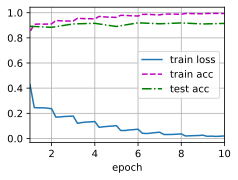

In [9]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Summary

* Nested function classes are desirable. Learning an additional layer in deep neural networks as an identity function (though this is an extreme case) should be made easy.
* The residual mapping can learn the identity function more easily, such as pushing parameters in the weight layer to zero.
* We can train an effective deep neural network by having residual blocks. Inputs can forward propagate faster through the residual connections across layers.
* ResNet had a major influence on the design of subsequent deep neural networks, both for convolutional and sequential nature.


## Exercises

1. What are the major differences between the Inception block in :numref:`fig_inception` and the residual block? After removing some paths in the Inception block, how are they related to each other?
1. Refer to Table 1 in the ResNet paper :cite:`He.Zhang.Ren.ea.2016` to
   implement different variants.
1. For deeper networks, ResNet introduces a "bottleneck" architecture to reduce
   model complexity. Try to implement it.
1. In subsequent versions of ResNet, the authors changed the "convolution, batch
   normalization, and activation" structure to the "batch normalization,
   activation, and convolution" structure. Make this improvement
   yourself. See Figure 1 in :cite:`He.Zhang.Ren.ea.2016*1`
   for details.
1. Why can't we just increase the complexity of functions without bound, even if the function classes are nested?


[Discussions](https://discuss.d2l.ai/t/86)


## My exercise solutions

2. Refer to Table 1 in the ResNet paper :cite:He.Zhang.Ren.ea.2016 to implement different variants.

Let me implement ResNet 50 (the paper can be found here: https://arxiv.org/pdf/1512.03385.pdf, page 5):

I'll have to make my own residual block:

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):  #@save
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels, strides=1): 
        # I removed the use_conv_1x1 attribute since I always adjust both X and Y
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=1,
                               stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(num_channels, num_channels * 4, kernel_size=1) # no padding doesn't change the 
                                                                              # image shape
        self.conv4 = nn.Conv2d(num_channels*4, num_channels, 
                               kernel_size=1) # used to adjust Y
        self.conv5 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=1, stride=strides) # used to adjust X
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.bn3 = nn.BatchNorm2d(num_channels * 4)

    def forward(self, X):
        # debug purpose prints are commented out
        #print("-----------------------------------")
        #print("X.shape:")
        #print(X.shape)
        Y = F.relu(self.bn1(self.conv1(X)))
        #print("Y.shape:")
        #print(Y.shape)
        Y = F.relu(self.bn2(self.conv2(Y)))
        #print("Y.shape:")
        #print(Y.shape)
        Y = F.relu(self.bn3(self.conv3(Y)))
        #print("Y.shape:")
        #print(Y.shape)
        Y = self.conv4(Y)
        #print("Y.shape:")
        #print(Y.shape)
        #print("X.shape:")
        #print(X.shape)
        X = self.conv5(X)
        #print("X.shape:")
        #print(X.shape)
        #print("-----------------------------------")
        Y += X
        return F.relu(Y)

Let's test it:

In [2]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [3]:
blk = Residual(3, 6, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

Now let's build a model:

In [4]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The same function as before:

In [5]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, 
                         strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [6]:
b2 = nn.Sequential(*resnet_block(64, 64, 3, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 4))
b4 = nn.Sequential(*resnet_block(128, 256, 6))
b5 = nn.Sequential(*resnet_block(256, 512, 3))

In [7]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

Let's test it on dummy input:

In [8]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    print("X.shape:")
    print(X.shape)
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

X.shape:
torch.Size([1, 1, 224, 224])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
X.shape:
torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
X.shape:
torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
X.shape:
torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
X.shape:
torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
X.shape:
torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
X.shape:
torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
X.shape:
torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


/home/mislav/anaconda3/envs/d2l/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Let's try training the model:

loss 0.152, train acc 0.944, test acc 0.896
86.8 examples/sec on cuda:0


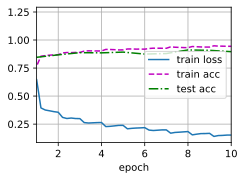

In [9]:
lr, num_epochs, batch_size = 0.005, 10, 32
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Note: The code above had NaN loss and 0.1 training and test accuracy when learning rate was equal to 0.05, while when I decreased the learning rate to 0.005 the training went smoothly

5. In subsequent versions of ResNet, the authors changed the "convolution, batch normalization, and activation" structure to the "batch normalization, activation, and convolution" structure. Make this improvement yourself. See Figure 1 in :cite:He.Zhang.Ren.ea.2016*1 for details.

Let me try this on ResNet18:

In [10]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):  #@save
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        #self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = self.conv1(F.relu(self.bn1(X)))
        Y = F.relu(self.bn2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return self.conv2(Y)

In [11]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [12]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [13]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [14]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, use_1x1conv=True,
                         strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [15]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [16]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [17]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.084, train acc 0.973, test acc 0.907
279.6 examples/sec on cuda:0


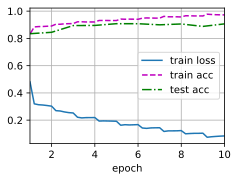

In [18]:
lr, num_epochs, batch_size = 0.005, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Note: The code above had NaN loss and 0.1 training and test accuracy when learning rate was equal to 0.05, while when I decreased the learning rate to 0.005 the training went smoothly